# Data Science Final Project

## Ethnic Differences- Cost Of Living
#### authors: Yossi Abu, Chen Kachlon

## Imports

In [5]:
import os
import json
import pandas as pd
import numpy as np
import pandas_profiling as pp
import requests
import math
import pycountry_convert as pc
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from geopy.geocoders import Nominatim
import folium
%matplotlib inline

## Functions

### Classifier functions

In [2]:
def changeCols(df):
    '''
    change dataframe colums from kaggle url
    '''
    url = 'https://www.kaggle.com/datasets/mvieira101/global-cost-of-living'
    html = requests.get(url).content.decode('utf-8')
    temp_str = html.split('Data dictionary')[1].split('|\\n|')[4:59]
    numeric_cols = [temp.split('|')[1].strip() for temp in temp_str]
    temp_cols = [col for col in numeric_cols]
    cols = []
    for col in temp_cols:
        if '(USD)' in col:
            cols.append(' '.join(col.split(' ')[:-1]))
        else:
            cols.append(col)
    cols = ['city', 'country'] + cols # + ['data_quality']
    cols = np.array(cols, object)
    df.columns = cols

In [3]:
def nanToMean(df):
    '''
    replace all nan values to mean of column group by country
    '''
    def get_nan_cols(df):
        temp = pd.DataFrame(df.isna().sum())
        temp = temp[temp[0] != 0]
        return temp.index
    def createDfMeanByCountry(df):
        x = pd.DataFrame(columns=df.columns).drop(columns='city')
        def meanRowByCountry(_country):
            df2 = df[df['country']==_country].reset_index(drop=True)
            return [_country] + list(df2.mean(numeric_only=True))
        for i in set(df['country'].values):
            x.loc[len(x)] = meanRowByCountry(i)
        return x.reset_index(drop=True)
    meanDfByCountry = createDfMeanByCountry(df)
    nan_cols = get_nan_cols(df)
    n = df[['country', 'city'] + list(nan_cols)]
    for idx, row in n.iterrows():
        for col in nan_cols:
            if math.isnan(row[col]):
                val = meanDfByCountry[(meanDfByCountry['country']==row['country'])][col]
                if not math.isnan(val):
                    df.at[idx, col] = float(round(val,2))
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

In [4]:
def country_to_continent(country_name):
    '''
    get country as str.
    return the continent that the country belongs
    '''
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [5]:
def get_continent_column(df):
    '''
    make a dictionary of countries from df.
    key = country, value = continent.
    if there is no continent for some country => value = unknown.
    iter the df rows and assign to each row the continent value.
    '''
    x = dict.fromkeys(set(df.country), 'unknown')
    for i in x:
        try:
            x[i] = country_to_continent(i)
        except:
            x[i] = 'unknown'
    for i in range(len(df)):
        df.loc[i,'continent'] = x[df['country'][i]]
    df = df[['city', 'country', 'continent'] + list(df.columns[2:-1])]
    return df[list(df.columns[:56]) + list(df.columns[56:][::-1])]

### Visualization functions

In [6]:
def change_df_ratio(df):
    df['International Primary School, Yearly for 1 Child'] /= 12
    cols = change_yearly_to_monthly(df)
    df.columns = cols
    return df

In [7]:
def change_yearly_to_monthly(df):
    cols = []
    for col in df.columns:
        if 'yearly for' in col.lower():
            cols.append(col.replace('Yearly', 'Monthly'))
        else:
            cols.append(col)
    return cols

In [8]:
def get_cities_mean_groupby_country(df, country):
    d = dict()
    country_df = df[df['country'] == country].reset_index(drop=True)
    for i in range(len(country_df)):
        d[country_df['city'][i]] = round(country_df.loc[i:i+1].values[0][3:-1].mean(), 2)
    return get_mean_df(d.keys(), d.values())

In [9]:
def get_country_mean(df, country_set, col=None):
    d = dict()
    if col:
        for country in country_set:
            d[country] = round(df[df.country == country][col].mean(), 2)
    else:
        for country in country_set:
            d[country] = get_cities_mean_groupby_country(df, country)['mean_value'].mean()
    return get_mean_df(d.keys(), d.values())

In [10]:
def get_mean_df(keys, values):
    mean_df = pd.DataFrame(values, index=keys)
    mean_df.columns = ['mean_value']
    return mean_df.sort_values(by=['mean_value'], ascending=False)

In [11]:
def get_cities_mean(df):
    d = dict()
    for i in range(len(df)):
        d[df['city'][i]] = df.loc[i:i+1].values[0][3:-1].mean()
    return get_mean_df(d.keys(), d.values())

In [12]:
def get_index_from_series(series, value):
    return series.index.to_list().index(value) + 1

In [13]:
def get_mean_categories_df(df):
    
    def get_categories_dfs(df):
        restaurants_df = df[list(df.columns[:3]) + list(df.columns[3:11])]
        markets_df = df[list(df.columns[:3]) + list(df.columns[11:30])]
        transportation_df = df[list(df.columns[:3]) + list(df.columns[30:38])]
        utilities_monthly_df = df[list(df.columns[:3]) + list(df.columns[38:41])]
        sports_and_leisure_df = df[list(df.columns[:3]) + list(df.columns[41:44])]
        childcare_df = df[list(df.columns[:3]) + list(df.columns[44:46])]
        fashion_df = df[list(df.columns[:3]) + list(df.columns[46:50])]
        rent_monthly_df = df[list(df.columns[:3]) + list(df.columns[50:54])]
        real_estate_df = df[list(df.columns[:3]) + list(df.columns[54:56])]
        economics_df = df[list(df.columns[:3]) + list(df.columns[56:58])]
        return  restaurants_df, markets_df, transportation_df, utilities_monthly_df, sports_and_leisure_df, \
                childcare_df, fashion_df, rent_monthly_df, real_estate_df, economics_df
    
    data = []
    categories_df = get_categories_dfs(df)
    for i in range(len(categories_df)-1):
        data.append([])
        for k in range(len(categories_df[i])):
            data[i].append(round(categories_df[i].loc[k].values[3:].mean(), 2))
    cols = ['restaurants', 'markets', 'transportation', 'utilities_monthly', 'sports_leisure', \
            'childcare', 'fashion', 'rent_monthly', 'real_estate']
    df_temp = pd.DataFrame(np.array(data)).T
    df_temp.columns = cols
    categories_df[-1].columns = ['city', 'country', 'continent', 'mortgage', 'average_income']
    df_temp = pd.concat([df_temp, categories_df[-1]], axis=1)
    return df_temp[['city', 'country', 'continent'] + cols + list(categories_df[-1].columns[3:])]

In [14]:
def get_sorted_col_corr(col, corr_matrix):
    return pd.DataFrame(corr_matrix.sort_values(col, ascending=False)[col])

In [15]:
def get_country_mean_groupby_country(df, country):
    mean_list = []
    for col in df.columns[3:]:
        if col != 'average_income':
            mean_list.append(df[df.country == country][col].mean())
    return np.mean(mean_list)

In [16]:
def get_total_mean(df, min_rows=None):
    d = dict()
    for country in country_set:
        if min_rows:
            if len(df[df.country == country]) >= min_rows:
                d[country] = get_country_mean_groupby_country(df, country)
        else:
            d[country] = get_country_mean_groupby_country(df, country)
    return get_mean_df(d.keys(), d.values())

In [17]:
def position_df(df_top, df_help):
    df = df_top.copy()
    for i in range(len(df)):
        df.loc[df.index[i], 'position'] = str(get_index_from_series(df_help, df_top.index[i]))
    return df

In [18]:
def classify_countries(country_set):
    low_countries = []
    for country in country_set:
        if mean_salary.loc[country]['mean_value'] <= most_expensive_countries.loc[country]['mean_value']:
            low_countries.append(country)
    low_countries = set(low_countries)
    high_countries = country_set - low_countries
    return low_countries, high_countries

In [19]:
def plot_top_countries(df, country_set, col, n=15, cheap=True):
    if cheap:
        return get_country_mean(df, country_set, col)[::-1][:n].plot(kind='barh', color='lightgreen'), plt.show()
    else:
        return get_country_mean(df, country_set, col)[:n].plot(kind='barh', color='lightgreen'), plt.show()

In [20]:
def add_salary_to_mean(df, mean_salary):
    df2 = df.copy()
    for i in range(len(df2)):
        df2.loc[df.index[i], 'mean_salary'] = mean_salary.loc[df2.index[i]]['mean_value']
    df2['ratio'] = -df2['mean_value'] + df2['mean_salary']
    return df2.sort_values(['ratio'], ascending=False)

In [21]:
def make_facetGrid_df(most_expensive_countries):
    df_temp = most_expensive_countries.copy()
    salary = []
    continent = []
    level = []
    for i in range(len(df_temp)):
        salary.append(mean_salary.loc[df_temp.index[i]].values[0])
        continent.append(df[df.country == df_temp.index[i]].continent.values[0])
        if df_temp.index[i] in low_countries:
            level.append('low')
        else:
            level.append('high')
    df_temp['mean_salary'] = salary
    df_temp['level'] = level
    df_temp['continent'] = continent
    df_temp['country'] = df_temp.index
    df_temp.reset_index(drop=True, inplace=True)
    return df_temp[df_temp.columns[::-1]]

In [98]:
def top_countries_for_category(df, country_set, category):
    print('Most expensive countries in ' + category + ':')
    plot_top_countries(df, country_set, category, cheap=False)
    print('\nCheapest countries in ' + category + ':')
    plot_top_countries(df, country_set, category)
    temp = get_country_mean(df, country_set, category)
    israel = get_index_from_series(temp, 'Israel')
    usa = get_index_from_series(temp, 'United States')
    print('Israel location: {0}\nUnited States location: {1}'.format(israel, usa))
    plt.show()

In [2]:
def nameCountry(df):
    url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
    state_geo = f"{url}/world-countries.json"
    geo_json_data = json.loads(requests.get(state_geo).text)
    lstState = []
    for i in range(len(geo_json_data['features'])):
        lstState.append(geo_json_data['features'][i]['properties']['name'])
    lstState = list(set(lstState))
    lstState.sort()
    x = list(set(df['country']))
    x.sort()
    allcountries = list(set(x+lstState))
    allcountries.sort()
    nonInstatedata, nonInjasonfile=[], []
    for i in allcountries:
        if i not in x:
            nonInstatedata.append(i)
        if i not in lstState:
            nonInjasonfile.append(i)
    nonInstatedata=list(set(nonInstatedata))
    nonInjasonfile=list(set(nonInjasonfile))
    nonInstatedata.sort()
    nonInjasonfile.sort()
    for i in range(len(df)):
        for k in nonInjasonfile:
            if df['country'][i]==k:
                for j in nonInstatedata:
                    if geolocate(k)==geolocate(j):
                        df.loc[i,"country"]=j
                        break
                break

In [3]:
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return [loc.latitude, loc.longitude]
    except:
        # Return missing value
        return np.nan

## Dataset Download
##### Remove from markdown for use 

kagglePath = '/home/yossi/.kaggle/kaggle.json'
api_token = {"username":"yossiabu","key":"df75a3186740c346f9de87cbed4f6d00"}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive
with open(kagglePath, 'w') as file:
    json.dump(api_token, file)
!chmod 600 /home/yossi/.kaggle/kaggle.json 

!kaggle datasets download -d mvieira101/global-cost-of-living -p ./datasets/global-cost-of-living
!unzip ./datasets/global-cost-of-living/*.zip  -d ./datasets/global-cost-of-living/

## Data reading + preprocessing

#### The data contains 2 csv files, v2 is more updated so we choose to work with him
#### We drop data_quality column just for the experiment (for getting more data)

In [23]:
df = pd.read_csv('./datasets/global-cost-of-living/cost-of-living_v2.csv').drop(['data_quality'], axis=1)
df

,city,country,x1,x2,x3,x4,x5,x6,x7,x8,...,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55
0,Seoul,South Korea,7.68,53.78,6.15,3.07,4.99,3.93,1.48,0.79,...,70.81,110.36,742.54,557.52,2669.12,1731.08,22067.70,10971.90,2689.62,3.47
1,Shanghai,China,5.69,39.86,5.69,1.14,4.27,3.98,0.53,0.33,...,88.21,123.51,1091.93,569.88,2952.70,1561.59,17746.11,9416.35,1419.87,5.03
2,Guangzhou,China,4.13,28.47,4.98,0.85,1.71,3.54,0.44,0.33,...,66.73,43.89,533.28,317.45,1242.24,688.05,12892.82,5427.45,1211.68,5.19
3,Mumbai,India,3.68,18.42,3.68,2.46,4.30,2.48,0.48,0.19,...,49.87,41.17,522.40,294.05,1411.12,699.80,6092.45,2777.51,640.81,7.96
4,Delhi,India,4.91,22.11,4.30,1.84,3.68,1.77,0.49,0.19,...,49.99,36.50,229.84,135.31,601.02,329.15,2506.73,1036.74,586.46,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4951,Peterborough,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4952,Georgetown,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4953,Ixtapa Zihuatanejo,Mexico,5.16,30.94,12.89,0.98,NaN,1.80,0.62,0.41,...,77.35,103.14,412.55,257.84,515.69,412.55,NaN,NaN,NaN,NaN
4954,Iqaluit,Canada,29.65,74.27,13.71,6.67,8.89,3.71,3.52,4.08,...,NaN,NaN,NaN,NaN,2964.60,2964.60,NaN,NaN,NaN,6.53


In [24]:
print(f'Shape = {df.shape}')
f'Count of nan = {sum(df.isna().sum())}'

Shape = (4956, 57)


'Count of nan = 45858'

In [25]:
changeCols(df)
nanToMean(df)

In [26]:
print(f'Shape = {df.shape}')
f'Count of nan = {sum(df.isna().sum())}'

Shape = (4849, 57)


'Count of nan = 0'

### Adding continent for each row, change ratio of col from yearly to monthly 

In [27]:
df = get_continent_column(df)
df = change_df_ratio(df)
df

,city,country,continent,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),"Domestic Beer (0.5 liter draught, in restaurants)","Imported Beer (0.33 liter bottle, in restaurants)","Cappuccino (regular, in restaurants)","Coke/Pepsi (0.33 liter bottle, in restaurants)",...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Average Monthly Net Salary (After Tax)
0,Seoul,South Korea,Asia,7.68,53.78,6.15,3.07,4.99,3.93,1.48,...,70.81,110.36,742.54,557.52,2669.12,1731.08,22067.70,10971.90,3.47,2689.62
1,Shanghai,China,Asia,5.69,39.86,5.69,1.14,4.27,3.98,0.53,...,88.21,123.51,1091.93,569.88,2952.70,1561.59,17746.11,9416.35,5.03,1419.87
2,Guangzhou,China,Asia,4.13,28.47,4.98,0.85,1.71,3.54,0.44,...,66.73,43.89,533.28,317.45,1242.24,688.05,12892.82,5427.45,5.19,1211.68
3,Mumbai,India,Asia,3.68,18.42,3.68,2.46,4.30,2.48,0.48,...,49.87,41.17,522.40,294.05,1411.12,699.80,6092.45,2777.51,7.96,640.81
4,Delhi,India,Asia,4.91,22.11,4.30,1.84,3.68,1.77,0.49,...,49.99,36.50,229.84,135.31,601.02,329.15,2506.73,1036.74,8.06,586.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,Egilsstadhir,Iceland,Europe,17.01,70.87,8.50,4.25,3.54,3.90,1.77,...,141.74,146.00,637.85,531.54,1700.92,1417.43,2019.84,1771.79,5.00,2480.51
4845,Peterborough,Australia,Oceania,15.42,62.47,8.85,5.57,5.60,3.22,2.43,...,93.83,97.64,1229.02,930.73,1844.87,1567.37,4986.07,3651.01,3.45,3521.60
4846,Georgetown,Australia,Oceania,15.42,62.47,8.85,5.57,5.60,3.22,2.43,...,93.83,97.64,1229.02,930.73,1844.87,1567.37,4986.07,3651.01,3.45,3521.60
4847,Ixtapa Zihuatanejo,Mexico,North America,5.16,30.94,12.89,0.98,3.08,1.80,0.62,...,77.35,103.14,412.55,257.84,515.69,412.55,1101.17,794.52,10.92,630.19


In [28]:
country_set = set(df['country'])
print('we have', len(country_set), 'different countries')

we have 153 different countries


## Visualizations

### Top 10 countries (appearences)

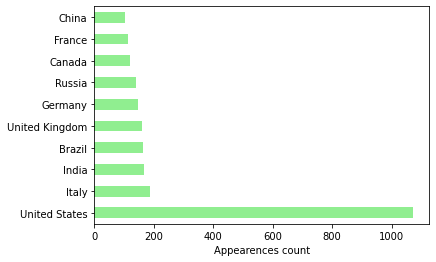

In [29]:
df['country'].value_counts()[0:10].plot(kind='barh', color="lightgreen")
plt.xlabel('Appearences count')
plt.show()

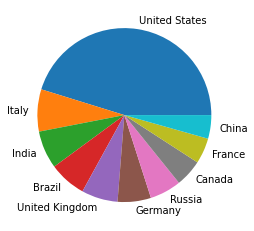

In [30]:
df.country.value_counts()[0:10].plot(kind='pie')
plt.ylabel('')
plt.show()

### Continent distribution

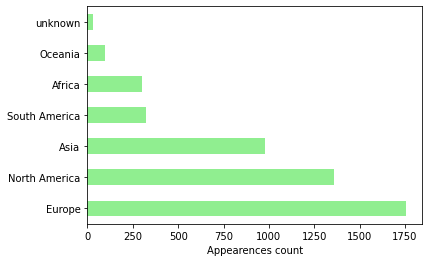

In [31]:
df.continent.value_counts().plot(kind='barh', color='lightgreen')
plt.xlabel('Appearences count')
plt.show()

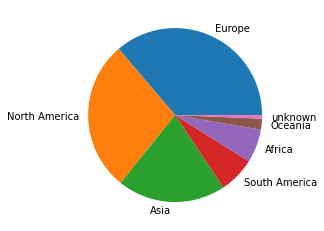

In [32]:
df.continent.value_counts().plot(kind='pie')
plt.ylabel('')
plt.show()

### Top 15 most expnesive countries

##### the mean value is mean of all numerical columns (without split to categories)

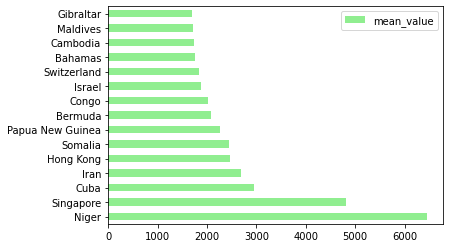

In [33]:
counries_mean = get_country_mean(df, country_set=country_set)
counries_mean[:15].plot(kind='barh', color='lightgreen')
plt.show()

### Israel placement

In [34]:
get_index_from_series(counries_mean, 'Israel')

10

### United States placement

In [35]:
get_index_from_series(counries_mean, 'United States')

50

### Top 15 most expnesive cities

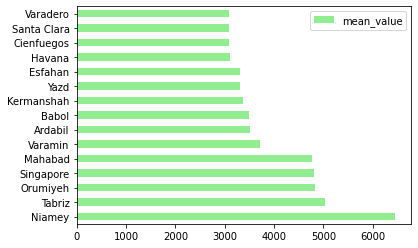

In [36]:
cities_mean = get_cities_mean(df)
cities_mean[:15].plot(kind='barh', color='lightgreen')
plt.show()

### Position of Tel Aviv-Yafo

In [37]:
get_index_from_series(cities_mean, 'Tel Aviv-Yafo')

48

### Position of New York

In [38]:
get_index_from_series(cities_mean, 'New York')

136

### Top 10 most expensive cities in Israel

In [39]:
position_df(get_cities_mean_groupby_country(df, 'Israel')[:10], cities_mean)

,mean_value,position
Tel Aviv-Yafo,2239.88,48
Hod HaSharon,2111.45,63
Nahariyya,2090.45,67
Herzliyya,2022.76,77
Jerusalem,2021.55,78
Petah Tiqwa,1982.17,83
Qiryat Ono,1957.72,90
Rehovot,1943.95,91
Netanya,1942.35,92
Ramat HaSharon,1936.74,94


### Top 10 most expensive cities in USA

In [40]:
position_df(get_cities_mean_groupby_country(df, 'United States')[:10], cities_mean)

,mean_value,position
Rock Hill,2120.97,60
Palm Bay,1974.87,86
Kearns,1933.96,95
Aliso Viejo,1933.54,96
Yucaipa,1858.99,117
Birch Bay,1845.53,120
New York,1810.37,136
Berkeley,1762.10,152
Edgewood,1743.40,159
East Lake,1743.05,160


### df mean calculate the mean value of every category df for each row

In [41]:
df_mean = get_mean_categories_df(df)
df_mean

,city,country,continent,restaurants,markets,transportation,utilities_monthly,sports_leisure,childcare,fashion,rent_monthly,real_estate,mortgage,average_income
0,Seoul,South Korea,Asia,10.23,7.00,7136.36,68.26,27.94,948.01,71.45,1425.06,16519.80,3.47,2689.62
1,Shanghai,China,Asia,7.69,4.04,5090.25,27.70,28.99,1790.45,79.28,1544.02,13581.23,5.03,1419.87
2,Guangzhou,China,Asia,5.56,3.08,5346.66,25.44,20.56,1300.77,51.97,695.26,9160.14,5.19,1211.68
3,Mumbai,India,Asia,4.46,2.38,4385.08,17.64,13.69,206.98,37.89,731.84,4434.98,7.96,640.81
4,Delhi,India,Asia,4.91,2.17,4404.73,22.01,11.57,118.84,38.01,323.83,1771.74,8.06,586.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,Egilsstadhir,Iceland,Europe,13.91,5.35,6216.18,62.29,30.12,177.18,115.94,1071.94,1895.82,5.00,2480.51
4845,Peterborough,Australia,Oceania,13.19,5.34,4801.52,67.46,23.69,1186.59,73.78,1393.00,4318.54,3.45,3521.60
4846,Georgetown,Australia,Oceania,13.19,5.34,4801.52,67.46,23.69,1186.59,73.78,1393.00,4318.54,3.45,3521.60
4847,Ixtapa Zihuatanejo,Mexico,North America,6.98,2.81,4497.92,34.97,19.77,244.73,61.88,399.66,947.84,10.92,630.19


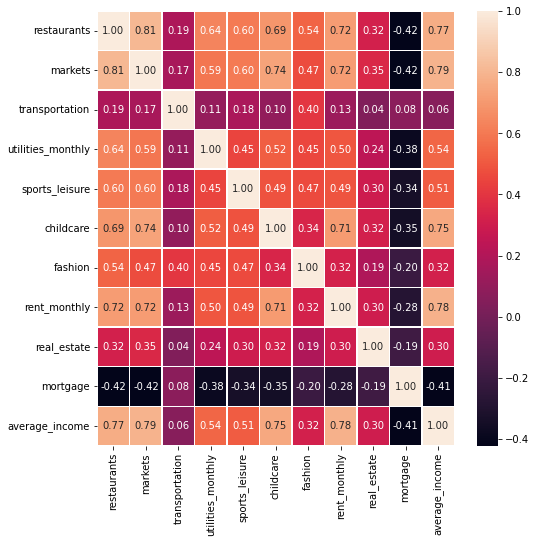

In [42]:
f,ax = plt.subplots(figsize=(8, 8))
corr_matrix = df_mean.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

### Most important correlations

In [43]:
get_sorted_col_corr('restaurants', corr_matrix)[1:6]

,restaurants
markets,0.806766
average_income,0.768551
rent_monthly,0.715530
childcare,0.690246
utilities_monthly,0.637628


In [44]:
get_sorted_col_corr('markets', corr_matrix)[1:6]

,markets
restaurants,0.806766
average_income,0.792025
childcare,0.735575
rent_monthly,0.715780
sports_leisure,0.603971


In [45]:
get_sorted_col_corr('average_income', corr_matrix)[1:6]

,average_income
markets,0.792025
rent_monthly,0.783839
restaurants,0.768551
childcare,0.753518
utilities_monthly,0.541475


In [46]:
get_sorted_col_corr('utilities_monthly', corr_matrix)[1:6]

,utilities_monthly
restaurants,0.637628
markets,0.591478
average_income,0.541475
childcare,0.521752
rent_monthly,0.498163


In [47]:
get_sorted_col_corr('rent_monthly', corr_matrix)[1:6]

,rent_monthly
average_income,0.783839
markets,0.715780
restaurants,0.715530
childcare,0.706800
utilities_monthly,0.498163


In [48]:
get_sorted_col_corr('mortgage', corr_matrix)[1:]

,mortgage
transportation,0.076349
real_estate,-0.187875
fashion,-0.204329
rent_monthly,-0.278640
sports_leisure,-0.338357
childcare,-0.349449
utilities_monthly,-0.378616
average_income,-0.414691
markets,-0.417618
restaurants,-0.422167


### Top 15 average salaries of each country

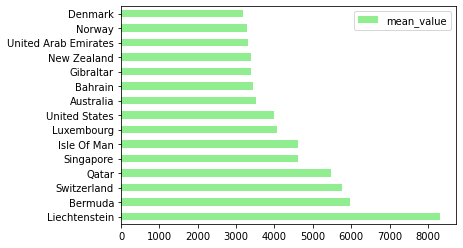

In [49]:
mean_salary = get_country_mean(df, country_set, 'Average Monthly Net Salary (After Tax)')
mean_salary[:15].plot(kind='barh', color='lightgreen')
plt.show()

### Average salary in Israel

In [50]:
mean_salary.loc['Israel']['mean_value']

2511.75

In [51]:
get_index_from_series(mean_salary, 'Israel')

26

### Average salary in United States

In [52]:
mean_salary.loc['United States']['mean_value']

3992.95

In [53]:
get_index_from_series(mean_salary, 'United States')

8

### Most expensive countries is mean of all the mean df group by country
##### Remember mean df contains only the categorical column. for each row, column value is mean of the category 

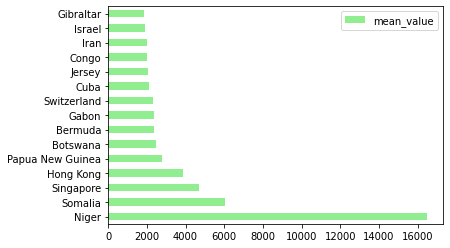

In [54]:
most_expensive_countries = get_total_mean(df_mean)
most_expensive_countries[:15].plot(kind='barh', color='lightgreen')
plt.show()

### Israel placement

In [55]:
get_index_from_series(most_expensive_countries, 'Israel')

14

### United States placement

In [56]:
get_index_from_series(most_expensive_countries, 'United States')

39

### The richest countries
#### Ratio = - (mean + salary)

In [57]:
df_composite = add_salary_to_mean(most_expensive_countries, mean_salary)
df_composite[:10]

,mean_value,mean_salary,ratio
Liechtenstein,1425.776400,8313.42,6887.643600
Qatar,1260.414000,5462.75,4202.336000
Bermuda,2349.684000,5973.81,3624.126000
Isle Of Man,1126.877000,4608.50,3481.623000
Switzerland,2330.499884,5760.71,3430.210116
United States,1239.967526,3992.95,2752.982474
Bahrain,831.622667,3434.30,2602.677333
Australia,1188.655125,3521.60,2332.944875
New Zealand,1082.975120,3383.97,2300.994880
Luxembourg,1811.416375,4075.22,2263.803625


### The poorest countries

In [58]:
df_composite.dropna().tail(10)[::-1]

,mean_value,mean_salary,ratio
Niger,16492.356000,211.51,-16280.846000
Somalia,6029.810667,378.34,-5651.470667
Papua New Guinea,2795.120800,401.85,-2393.270800
Cuba,2111.938222,189.79,-1922.148222
Gabon,2349.605000,461.85,-1887.755000
Botswana,2468.705667,726.90,-1741.805667
Iran,1993.101514,419.25,-1573.851514
Congo,2021.086400,579.25,-1441.836400
Senegal,1831.023667,441.77,-1389.253667
Rwanda,1705.506333,414.52,-1290.986333


### Israel placement

In [59]:
get_index_from_series(df_composite, 'Israel')

38

### United States placement

In [60]:
get_index_from_series(df_composite, 'United States')

6

### Countries classify 
#### low = negative ratio
#### high = positive ratio

In [61]:
low_countries, high_countries = classify_countries(country_set)

In [62]:
print(f'from {len(country_set)} countries:\nlow = {len(low_countries)}, high = {len(high_countries)}')

from 153 countries:
low = 90, high = 63


### Israel is high country!

In [63]:
'Israel' in high_countries

True

In [64]:
'United States' in high_countries

True

### Let's try to find most expensive countries that have at least 5 city in data frame

In [65]:
most_expensive_countries_5 = get_total_mean(df_mean, 5)

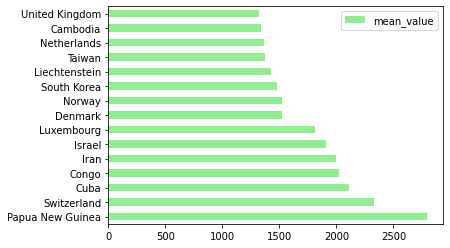

In [66]:
most_expensive_countries_5[:15].plot(kind='barh', color='lightgreen')
plt.show()

### Israel placement

In [67]:
get_index_from_series(most_expensive_countries_5, 'Israel')

6

### United States placement

In [68]:
get_index_from_series(most_expensive_countries_5, 'United States')

23

### The richest countries
#### Ratio = - (mean + salary)

In [69]:
df_composite = add_salary_to_mean(most_expensive_countries_5, mean_salary)
df_composite[:10]

,mean_value,mean_salary,ratio
Liechtenstein,1425.776400,8313.42,6887.643600
Switzerland,2330.499884,5760.71,3430.210116
United States,1239.967526,3992.95,2752.982474
Australia,1188.655125,3521.60,2332.944875
New Zealand,1082.975120,3383.97,2300.994880
Luxembourg,1811.416375,4075.22,2263.803625
United Arab Emirates,1074.864200,3310.75,2235.885800
Netherlands,1364.207927,3155.38,1791.172073
Canada,1209.325042,2966.00,1756.674958
Norway,1521.903800,3278.33,1756.426200


### The poorest countries

In [70]:
df_composite.dropna().tail(10)[::-1]

,mean_value,mean_salary,ratio
Papua New Guinea,2795.120800,401.85,-2393.270800
Cuba,2111.938222,189.79,-1922.148222
Iran,1993.101514,419.25,-1573.851514
Congo,2021.086400,579.25,-1441.836400
Cambodia,1335.875300,273.09,-1062.785300
Ethiopia,1144.283667,214.74,-929.543667
Nepal,1106.451727,190.50,-915.951727
Syria,917.789077,48.44,-869.349077
Mozambique,1105.315000,261.03,-844.285000
Nigeria,887.472194,132.61,-754.862194


### Israel placement

In [71]:
get_index_from_series(df_composite, 'Israel')

27

### United States placement

In [72]:
get_index_from_series(df_composite, 'United States')

3

### Countries classify

In [73]:
low_countries, high_countries = classify_countries(set(most_expensive_countries_5.index))

In [74]:
print(f'from {len(set(most_expensive_countries_5.index))} countries:\nlow = {len(low_countries)}, high = {len(high_countries)}')

from 117 countries:
low = 69, high = 48


### Let's find the most expensive/ cheapest countries for each category

Most expensive countries in restaurants:


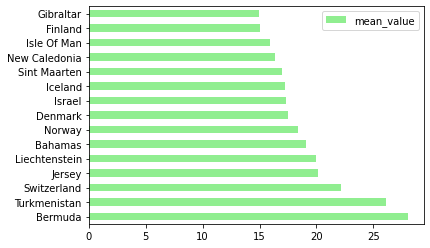


Cheapest countries in restaurants:


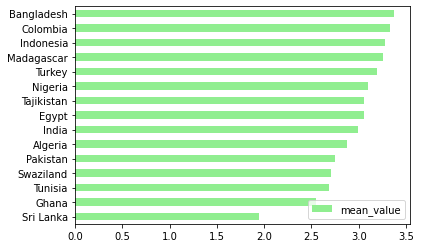

Israel location: 9
United States location: 22


In [99]:
top_countries_for_category(df_mean, country_set, 'restaurants')

Most expensive countries in markets:


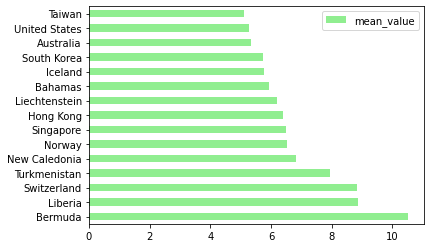


Cheapest countries in markets:


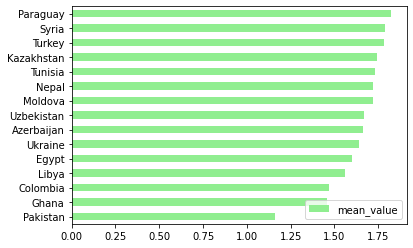

Israel location: 17
United States location: 14


In [100]:
top_countries_for_category(df_mean, country_set, 'markets')

Most expensive countries in transportation:


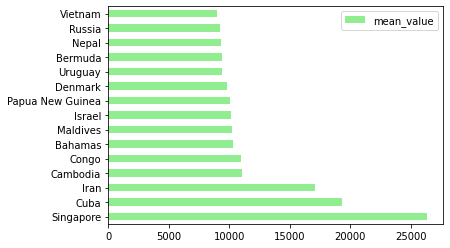


Cheapest countries in transportation:


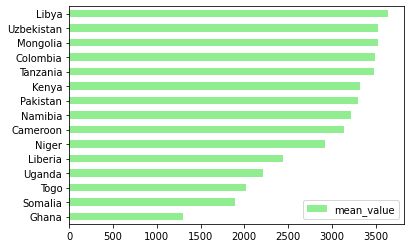

Israel location: 8
United States location: 68


In [101]:
top_countries_for_category(df_mean, country_set, 'transportation')

Most expensive countries in utilities_monthly:


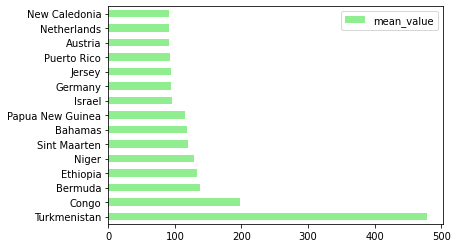


Cheapest countries in utilities_monthly:


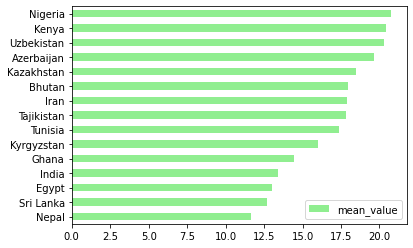

Israel location: 9
United States location: 24


In [102]:
top_countries_for_category(df_mean, country_set, 'utilities_monthly')

Most expensive countries in sports_leisure:


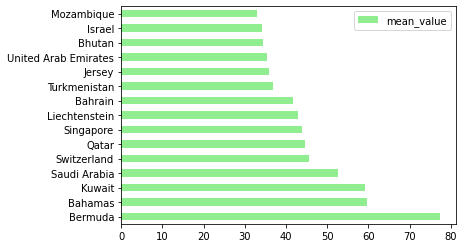


Cheapest countries in sports_leisure:


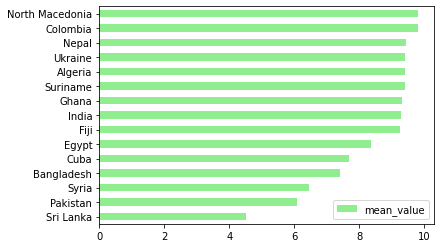

Israel location: 14
United States location: 51


In [103]:
top_countries_for_category(df_mean, country_set, 'sports_leisure')

Most expensive countries in childcare:


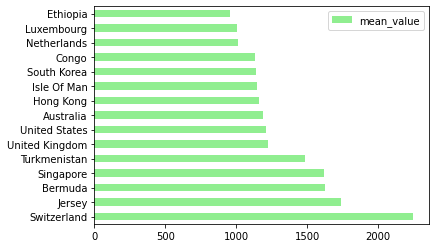


Cheapest countries in childcare:


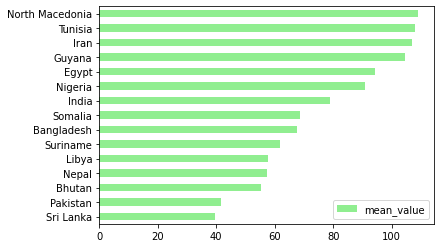

Israel location: 20
United States location: 7


In [104]:
top_countries_for_category(df_mean, country_set, 'childcare')

Most expensive countries in fashion:


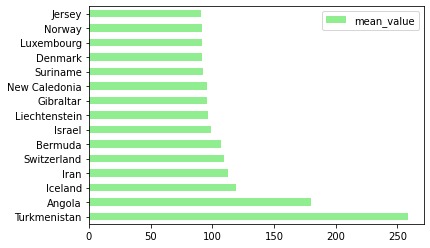


Cheapest countries in fashion:


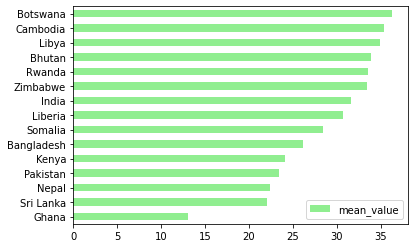

Israel location: 7
United States location: 63


In [105]:
top_countries_for_category(df_mean, country_set, 'fashion')

Most expensive countries in rent_monthly:


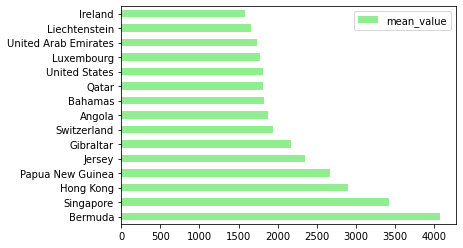


Cheapest countries in rent_monthly:


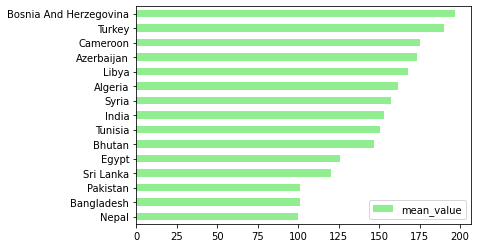

Israel location: 25
United States location: 11


In [106]:
top_countries_for_category(df_mean, country_set, 'rent_monthly')

Most expensive countries in real_estate:


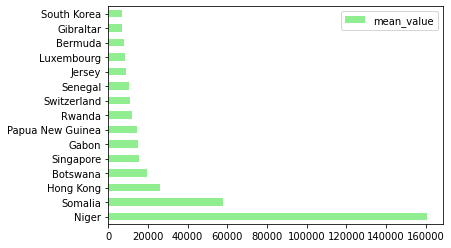


Cheapest countries in real_estate:


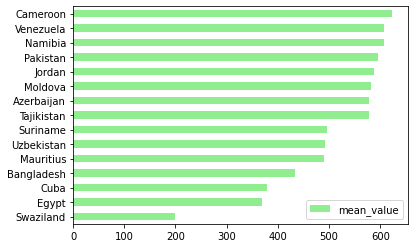

Israel location: 16
United States location: 45


In [107]:
top_countries_for_category(df_mean, country_set, 'real_estate')

### FacetGrid

In [84]:
df_fg = make_facetGrid_df(most_expensive_countries)
df_fg

,country,continent,level,mean_salary,mean_value
0,Niger,Africa,high,211.51,16492.356000
1,Somalia,Africa,high,378.34,6029.810667
2,Singapore,Asia,high,4619.45,4716.137000
3,Hong Kong,Asia,high,2994.43,3864.500000
4,Papua New Guinea,Oceania,low,401.85,2795.120800
...,...,...,...,...,...
148,Namibia,Africa,high,682.54,473.197000
149,Uzbekistan,Asia,low,242.04,459.563700
150,Cameroon,Africa,low,229.78,417.243857
151,Pakistan,Asia,low,154.27,411.223513


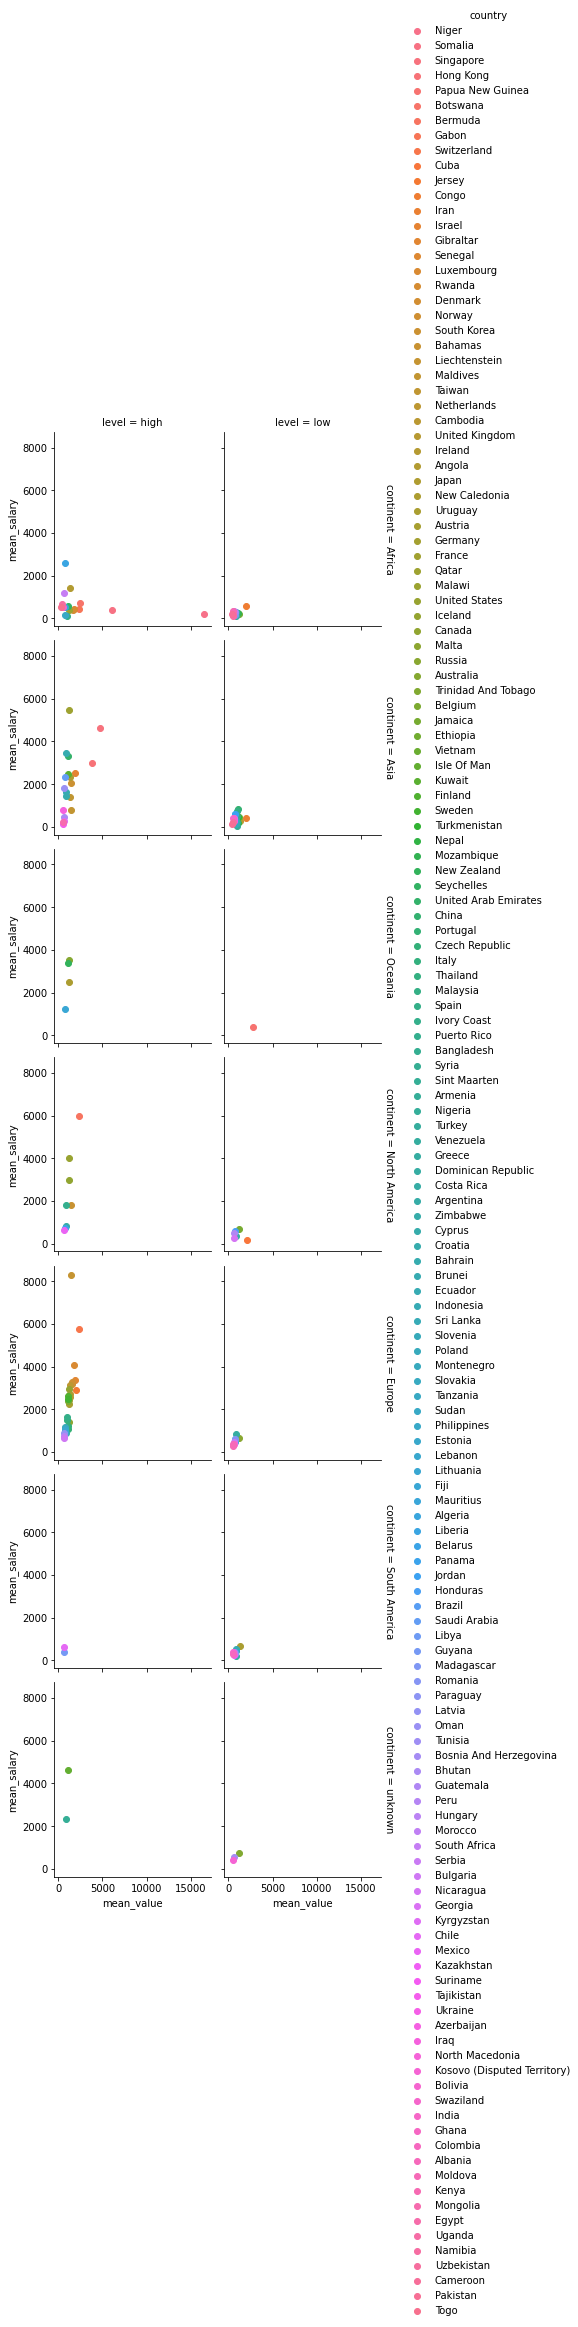

In [85]:
g = sns.FacetGrid(df_fg, col="level", row="continent", margin_titles=True, hue="country") 
g.map(plt.scatter, "mean_value", "mean_salary").add_legend()
plt.show()

In [86]:
df_fg = make_facetGrid_df(most_expensive_countries_5)
df_fg

,country,continent,level,mean_salary,mean_value
0,Papua New Guinea,Oceania,low,401.85,2795.120800
1,Switzerland,Europe,high,5760.71,2330.499884
2,Cuba,North America,low,189.79,2111.938222
3,Congo,Africa,low,579.25,2021.086400
4,Iran,Asia,low,419.25,1993.101514
...,...,...,...,...,...
112,Egypt,Africa,low,144.32,498.295238
113,Uganda,Africa,low,121.08,476.691300
114,Uzbekistan,Asia,low,242.04,459.563700
115,Cameroon,Africa,low,229.78,417.243857


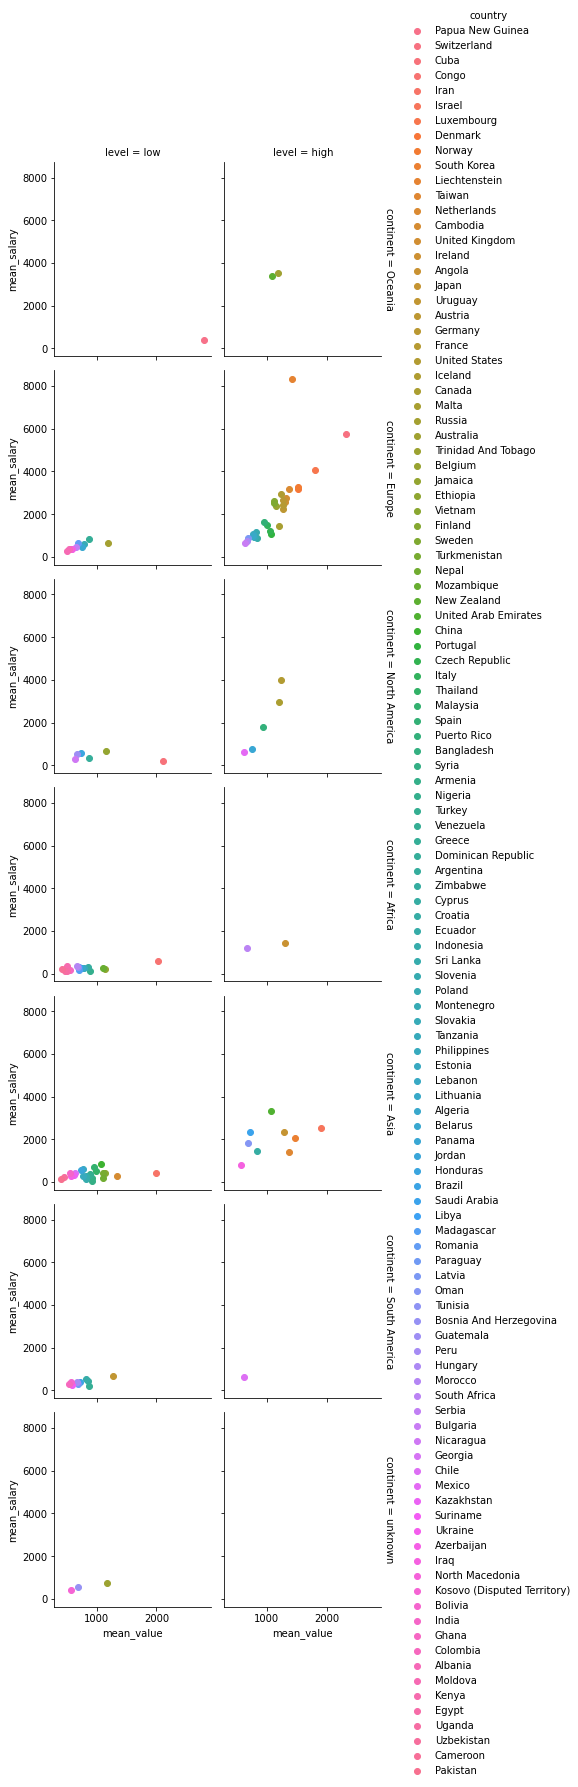

In [87]:
g = sns.FacetGrid(df_fg, col="level", row="continent", margin_titles=True, hue="country") 
g.map(plt.scatter, "mean_value", "mean_salary").add_legend()
plt.show()

### Bubble Chart

In [7]:
data_by_mean = pd.read_csv('./datasets/population/population_mean_country.csv.xls')
data_by_pop = data_by_mean.sort_values(by=['population'],ascending=False).reset_index(drop=True)
data_by_mean_5_cities = pd.read_csv('./datasets/population/population_mean_country_5_cities.csv.xls')
data_by_pop_5_cities = data_by_mean_5_cities.sort_values(by=['population'],ascending=False).reset_index(drop=True)

In [18]:
data_by_mean

,country,mean_value,population,continent
0,Niger,16492.356000,24346468.0,Africa
1,Somalia,6029.810667,15965848.0,Africa
2,Singapore,4716.137000,5858322.0,Asia
3,Hong Kong,3864.500000,7507523.0,Asia
4,Papua New Guinea,2795.120800,8975531.0,Oceania
...,...,...,...,...
148,Namibia,473.197000,2548663.0,Africa
149,Uzbekistan,459.563700,33551824.0,Asia
150,Cameroon,417.243857,26655083.0,Africa
151,Pakistan,411.223513,221612785.0,Asia


### Regular df

#### Most expnesive countries, hue=country

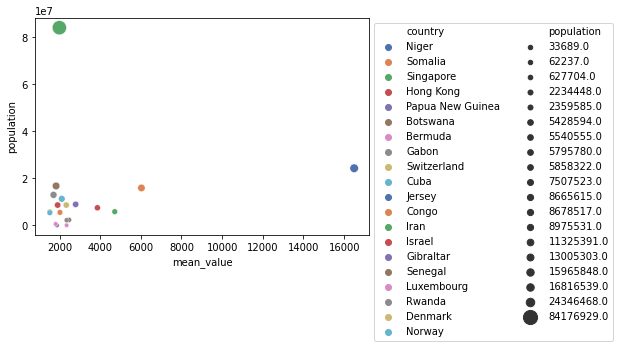

In [12]:
ax = sns.scatterplot(data=data_by_mean[:20], x="mean_value", y="population", size="population", legend="full", hue="country", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:7], labels=labels[:7])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

#### Most expnesive countries, hue=continent

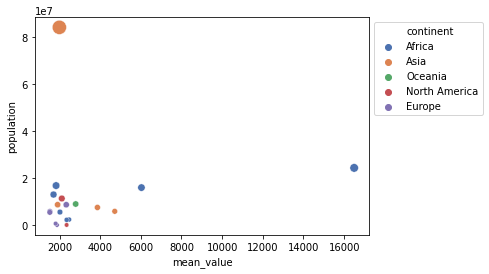

In [13]:
ax = sns.scatterplot(data=data_by_mean[:20], x="mean_value", y="population", size="population", legend="full", hue="continent", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:6], labels=labels[:6])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

#### Biggest population countries, hue=country

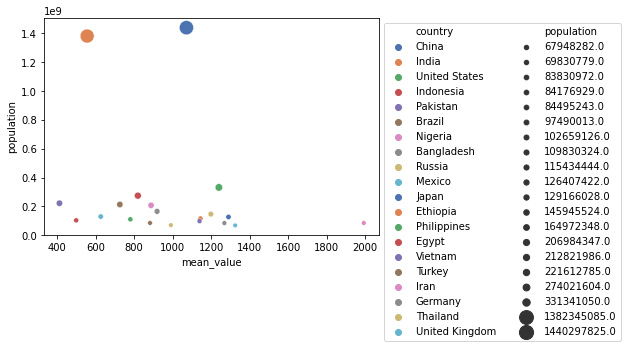

In [14]:
ax = sns.scatterplot(data=data_by_pop[:20], x="mean_value", y="population", size="population", legend="full", hue="country", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:7], labels=labels[:7])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

#### Biggest population countries, hue=continent

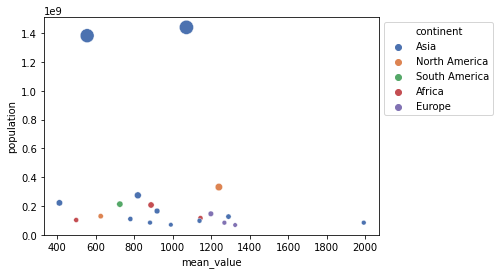

In [15]:
ax = sns.scatterplot(data=data_by_pop[:20], x="mean_value", y="population", size="population", legend="full", hue="continent", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:6], labels=labels[:6])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

### df contains countries with at least 5 cities 

#### Most expnesive countries, hue=country

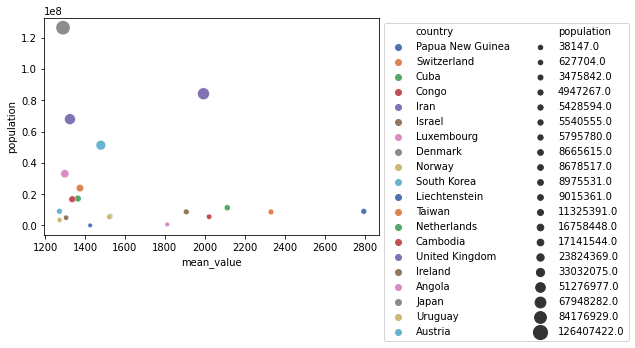

In [16]:
ax = sns.scatterplot(data=data_by_mean_5_cities[:20], x="mean_value", y="population", size="population", legend="full", hue="country", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:7], labels=labels[:7])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

#### Most expnesive countries, hue=continent

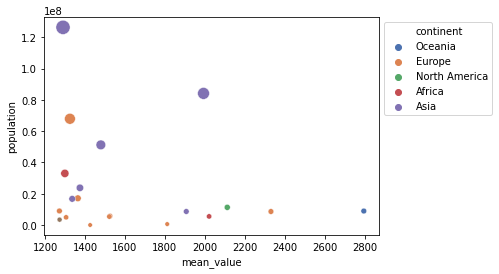

In [17]:
ax = sns.scatterplot(data=data_by_mean_5_cities[:20], x="mean_value", y="population", size="population", legend="full", hue="continent", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:6], labels=labels[:6])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

#### Biggest population countries, hue=country

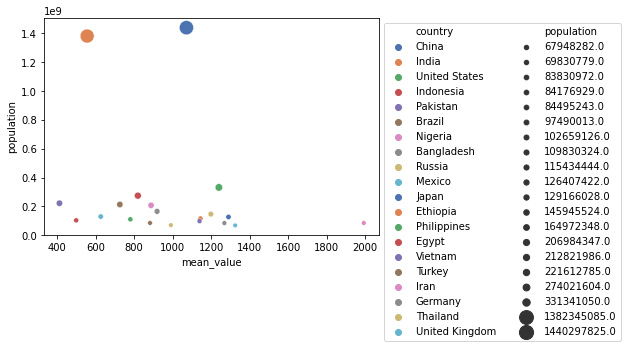

In [18]:
ax = sns.scatterplot(data=data_by_pop_5_cities[:20], x="mean_value", y="population", size="population", legend="full", hue="country", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:7], labels=labels[:7])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

#### Biggest population countries, hue=continent

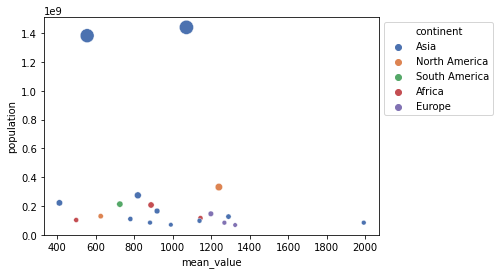

In [19]:
ax = sns.scatterplot(data=data_by_pop_5_cities[:20], x="mean_value", y="population", size="population", legend="full", hue="continent", palette="deep", sizes=(20, 200))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:6], labels=labels[:6])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [6]:
geolocator = Nominatim(user_agent="Geolocation")

In [26]:
nameCountry(df)
url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
state_geo = f"{url}/world-countries.json"
state_data =df[['country','mean_value']]
m = folium.Map()
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["country", 'mean_value'],
    key_on="feature.properties.name",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='mean_value',
).add_to(m)
folium.LayerControl().add_to(m)
m

## Classifier

### Remove all the rows that we couldn't found their continent

In [88]:
df = df[df.continent != 'unknown']
df

,city,country,continent,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),"Domestic Beer (0.5 liter draught, in restaurants)","Imported Beer (0.33 liter bottle, in restaurants)","Cappuccino (regular, in restaurants)","Coke/Pepsi (0.33 liter bottle, in restaurants)",...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Average Monthly Net Salary (After Tax)
0,Seoul,South Korea,Asia,7.68,53.78,6.15,3.07,4.99,3.93,1.48,...,70.81,110.36,742.54,557.52,2669.12,1731.08,22067.70,10971.90,3.47,2689.62
1,Shanghai,China,Asia,5.69,39.86,5.69,1.14,4.27,3.98,0.53,...,88.21,123.51,1091.93,569.88,2952.70,1561.59,17746.11,9416.35,5.03,1419.87
2,Guangzhou,China,Asia,4.13,28.47,4.98,0.85,1.71,3.54,0.44,...,66.73,43.89,533.28,317.45,1242.24,688.05,12892.82,5427.45,5.19,1211.68
3,Mumbai,India,Asia,3.68,18.42,3.68,2.46,4.30,2.48,0.48,...,49.87,41.17,522.40,294.05,1411.12,699.80,6092.45,2777.51,7.96,640.81
4,Delhi,India,Asia,4.91,22.11,4.30,1.84,3.68,1.77,0.49,...,49.99,36.50,229.84,135.31,601.02,329.15,2506.73,1036.74,8.06,586.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,Egilsstadhir,Iceland,Europe,17.01,70.87,8.50,4.25,3.54,3.90,1.77,...,141.74,146.00,637.85,531.54,1700.92,1417.43,2019.84,1771.79,5.00,2480.51
4845,Peterborough,Australia,Oceania,15.42,62.47,8.85,5.57,5.60,3.22,2.43,...,93.83,97.64,1229.02,930.73,1844.87,1567.37,4986.07,3651.01,3.45,3521.60
4846,Georgetown,Australia,Oceania,15.42,62.47,8.85,5.57,5.60,3.22,2.43,...,93.83,97.64,1229.02,930.73,1844.87,1567.37,4986.07,3651.01,3.45,3521.60
4847,Ixtapa Zihuatanejo,Mexico,North America,5.16,30.94,12.89,0.98,3.08,1.80,0.62,...,77.35,103.14,412.55,257.84,515.69,412.55,1101.17,794.52,10.92,630.19


###         Gradient Boosting Classifier

In [89]:
X = df[df.columns[3:]]
X

,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),"Domestic Beer (0.5 liter draught, in restaurants)","Imported Beer (0.33 liter bottle, in restaurants)","Cappuccino (regular, in restaurants)","Coke/Pepsi (0.33 liter bottle, in restaurants)","Water (0.33 liter bottle, in restaurants)","Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Average Monthly Net Salary (After Tax)
0,7.68,53.78,6.15,3.07,4.99,3.93,1.48,0.79,2.20,2.85,...,70.81,110.36,742.54,557.52,2669.12,1731.08,22067.70,10971.90,3.47,2689.62
1,5.69,39.86,5.69,1.14,4.27,3.98,0.53,0.33,2.74,2.61,...,88.21,123.51,1091.93,569.88,2952.70,1561.59,17746.11,9416.35,5.03,1419.87
2,4.13,28.47,4.98,0.85,1.71,3.54,0.44,0.33,1.91,1.63,...,66.73,43.89,533.28,317.45,1242.24,688.05,12892.82,5427.45,5.19,1211.68
3,3.68,18.42,3.68,2.46,4.30,2.48,0.48,0.19,0.75,0.50,...,49.87,41.17,522.40,294.05,1411.12,699.80,6092.45,2777.51,7.96,640.81
4,4.91,22.11,4.30,1.84,3.68,1.77,0.49,0.19,0.73,0.50,...,49.99,36.50,229.84,135.31,601.02,329.15,2506.73,1036.74,8.06,586.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,17.01,70.87,8.50,4.25,3.54,3.90,1.77,1.42,1.06,2.86,...,141.74,146.00,637.85,531.54,1700.92,1417.43,2019.84,1771.79,5.00,2480.51
4845,15.42,62.47,8.85,5.57,5.60,3.22,2.43,1.94,1.14,1.90,...,93.83,97.64,1229.02,930.73,1844.87,1567.37,4986.07,3651.01,3.45,3521.60
4846,15.42,62.47,8.85,5.57,5.60,3.22,2.43,1.94,1.14,1.90,...,93.83,97.64,1229.02,930.73,1844.87,1567.37,4986.07,3651.01,3.45,3521.60
4847,5.16,30.94,12.89,0.98,3.08,1.80,0.62,0.41,1.80,0.77,...,77.35,103.14,412.55,257.84,515.69,412.55,1101.17,794.52,10.92,630.19


### label = continent

In [90]:
'we have ' + str(len(df.continent.unique())) + ' different labels'

'we have 6 different labels'

### Label Encoder

In [91]:
X = X.apply(LabelEncoder().fit_transform)   
X

,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),"Domestic Beer (0.5 liter draught, in restaurants)","Imported Beer (0.33 liter bottle, in restaurants)","Cappuccino (regular, in restaurants)","Coke/Pepsi (0.33 liter bottle, in restaurants)","Water (0.33 liter bottle, in restaurants)","Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Average Monthly Net Salary (After Tax)
0,442,844,343,241,366,361,135,71,186,278,...,756,1410,1505,1441,2015,1855,2092,1983,201,2002
1,343,716,308,71,320,365,40,25,218,255,...,1262,1571,1817,1453,2062,1783,2083,1964,329,1452
2,241,530,248,43,96,323,31,25,158,157,...,639,303,1251,1076,1422,1177,2054,1818,344,1376
3,210,296,129,197,322,218,35,11,42,44,...,286,271,1240,1023,1534,1185,1840,1460,491,954
4,292,390,187,140,274,147,36,11,40,44,...,288,208,575,471,859,620,1218,774,498,875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,693,955,515,320,262,358,164,133,73,279,...,1732,1723,1380,1404,1690,1713,1051,1131,326,1893
4845,662,897,542,392,405,291,230,185,81,184,...,1383,1212,1898,1807,1759,1786,1718,1639,200,2361
4846,662,897,542,392,405,291,230,185,81,184,...,1383,1212,1898,1807,1759,1786,1718,1639,200,2361
4847,306,576,668,55,224,150,49,33,147,71,...,954,1303,1046,928,730,795,537,566,626,933


### Label = continent

In [92]:
y = df.continent

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the classifier
clf = GradientBoostingClassifier(n_estimators=100)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate the metrics of the predictions
print(classification_report(y_test, predictions))

               precision    recall  f1-score   support

       Africa       1.00      0.88      0.94        58
         Asia       0.96      1.00      0.98       193
       Europe       1.00      0.99      1.00       358
North America       1.00      1.00      1.00       268
      Oceania       0.91      0.91      0.91        23
South America       0.95      0.97      0.96        64

     accuracy                           0.99       964
    macro avg       0.97      0.96      0.96       964
 weighted avg       0.99      0.99      0.99       964



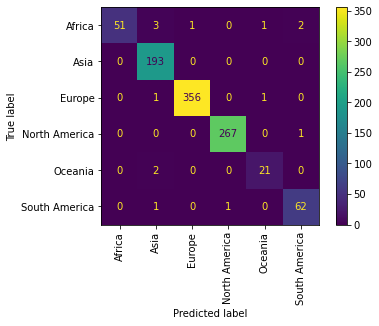

In [93]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=list(clf.classes_))
disp.plot()
plt.xticks(rotation=90)
plt.show()

### Label = country

In [94]:
'we have ' + str(len(df.country.unique())) + ' different labels'

'we have 148 different labels'

In [95]:
y = df.country

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the classifier
clf = GradientBoostingClassifier(n_estimators=100)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = (predictions == y_test).mean()
accuracy

0.8765560165975104

### Linear Regression

In [7]:
# Label Encoder
df = df.apply(LabelEncoder().fit_transform)   
df.head()

,city,country,continent,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),"Domestic Beer (0.5 liter draught, in restaurants)","Imported Beer (0.33 liter bottle, in restaurants)","Cappuccino (regular, in restaurants)","Coke/Pepsi (0.33 liter bottle, in restaurants)",...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Average Monthly Net Salary (After Tax)
0,3788,121,1,442,844,343,241,366,361,135,...,756,1410,1505,1441,2015,1855,2092,1983,201,2002
1,3812,24,1,343,716,308,71,320,365,40,...,1262,1571,1817,1453,2062,1783,2083,1964,329,1452
2,1642,24,1,241,530,248,43,96,323,31,...,639,303,1251,1076,1422,1177,2054,1818,344,1376
3,2809,53,1,210,296,129,197,322,218,35,...,286,271,1240,1023,1534,1185,1840,1460,491,954
4,1147,53,1,292,390,187,140,274,147,36,...,288,208,575,471,859,620,1218,774,498,875


### We are trying to predict the average income 

#### X = all columns except average income

In [12]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the classifier
clf = LinearRegression()

# Train the classifier on the training data
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# MAE
mae = mean_absolute_error(y_test, y_pred)
mae
# MSE
mse = mean_squared_error(y_test, y_pred)
mse
# RMSE
rmse = np.sqrt(mse)
rmse
# R-squared
r2 = r2_score(y_test, y_pred)
r2
print(f'MAE = {mae:.2f}\nMSE = {mse:.2f}\nRMSE = {rmse:.2f}\nR squared = {r2:.2f}')

MAE = 196.61
MSE = 64977.58
RMSE = 254.91
R squared = 0.90


'196.6064569784773, 64977.5756209962, 254.90699406057144, 0.9044276488105815'